In [3]:
import dask
import pystac_client
import planetary_computer as pc
import leafmap
import geogif
import stackstac
import leafmap

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 15.49 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35659,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 15.49 GiB
Comm: tcp://127.0.0.1:44415,Total threads: 1
Dashboard: http://127.0.0.1:40343/status,Memory: 3.87 GiB
Nanny: tcp://127.0.0.1:33069,


In [4]:
m = leafmap.Map(center=[41.64933994767867, -69.94438630063088], zoom=12, height="800px")
m

Map(center=[41.64933994767867, -69.94438630063088], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [5]:
bbox = (m.west, m.south, m.east, m.north)

In [6]:
catalog = pystac_client.Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')

search = catalog.search(
    collections=['landsat-8-c2-l2'],
    bbox=bbox,
)

In [7]:
%%time
items = pc.sign(search)
len(items)

CPU times: user 1.96 s, sys: 160 ms, total: 2.12 s
Wall time: 7.68 s


390

In [8]:
m.add_geojson(items.to_dict())
m

Map(bottom=391020.0, center=[41.64931448003169, -69.94445800781251], controls=(ZoomControl(options=['position'…

In [9]:
%%time
stack = stackstac.stack(items, bounds_latlon=bbox)
stack

CPU times: user 526 ms, sys: 25.9 ms, total: 552 ms
Wall time: 806 ms


<xarray.DataArray 'stackstac-9b05a59de0d0a53febaa5aecece8a274' (time: 390,
                                                                band: 19,
                                                                y: 773, x: 1172)>
dask.array<fetch_raster_window, shape=(390, 19, 773, 1172), dtype=float64, chunksize=(1, 1, 773, 1024), chunktype=numpy.ndarray>
Coordinates: (12/27)
  * time                         (time) datetime64[ns] 2013-03-22T15:19:00.54...
    id                           (time) <U31 'LC08_L2SP_011031_20130322_02_T1...
  * band                         (band) <U13 'SR_B1' 'SR_B2' ... 'SR_QA_AEROSOL'
  * x                            (x) float64 4.037e+05 4.038e+05 ... 4.389e+05
  * y                            (y) float64 4.623e+06 4.623e+06 ... 4.6e+06
    landsat:cloud_cover_land     (time) float64 90.98 1.51 15.5 ... 6.51 98.07
    ...                           ...
    gsd                          (band) float64 30.0 30.0 30.0 ... 30.0 30.0
    title                        (band) <U46 'Coastal/Aerosol Band (B1)' ... ...
    common_name                  (band) object 'coastal' 'blue' ... None None
    center_wavelength            (band) object 0.44 0.48 0.56 ... None None None
    full_width_half_max          (band) object 0.02 0.06 0.06 ... None None None
    epsg                         int64 32619
Attributes:
    spec:        RasterSpec(epsg=32619, bounds=(403740.0, 4599690.0, 438900.0...
    crs:         epsg:32619
    transform:   | 30.00, 0.00, 403740.00|\n| 0.00,-30.00, 4622880.00|\n| 0.0...
    resolution:  30.0

In [10]:
# Band names are not trivial from the initial query
stack.band

<xarray.DataArray 'band' (band: 19)>
array(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ST_QA',
       'ST_B10', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_TRAD', 'ST_URAD',
       'QA_PIXEL', 'ST_ATRAN', 'ST_CDIST', 'QA_RADSAT', 'SR_QA_AEROSOL'],
      dtype='<U13')
Coordinates: (12/16)
  * band                       (band) <U13 'SR_B1' 'SR_B2' ... 'SR_QA_AEROSOL'
    view:off_nadir             int64 0
    landsat:processing_level   <U4 'L2SP'
    description                (band) <U91 'Collection 2 Level-2 Coastal/Aero...
    instruments                object {'tirs', 'oli'}
    landsat:collection_number  <U2 '02'
    ...                         ...
    gsd                        (band) float64 30.0 30.0 30.0 ... 30.0 30.0 30.0
    title                      (band) <U46 'Coastal/Aerosol Band (B1)' ... 'A...
    common_name                (band) object 'coastal' 'blue' ... None None
    center_wavelength          (band) object 0.44 0.48 0.56 ... None None None
    full_width_half_max        (band) object 0.02 0.06 0.06 ... None None None
    epsg                       int64 32619

In [11]:
# Use common_name for bands
stack = stack.assign_coords(band=stack.common_name.fillna(stack.band).rename("band"))
stack.band

<xarray.DataArray 'band' (band: 19)>
array(['coastal', 'blue', 'green', 'red', 'nir08', 'swir16', 'swir22', 'ST_QA',
       'lwir11', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_TRAD', 'ST_URAD',
       'QA_PIXEL', 'ST_ATRAN', 'ST_CDIST', 'QA_RADSAT', 'SR_QA_AEROSOL'],
      dtype=object)
Coordinates: (12/16)
  * band                       (band) object 'coastal' ... 'SR_QA_AEROSOL'
    view:off_nadir             int64 0
    landsat:processing_level   <U4 'L2SP'
    description                (band) <U91 'Collection 2 Level-2 Coastal/Aero...
    instruments                object {'tirs', 'oli'}
    landsat:collection_number  <U2 '02'
    ...                         ...
    gsd                        (band) float64 30.0 30.0 30.0 ... 30.0 30.0 30.0
    title                      (band) <U46 'Coastal/Aerosol Band (B1)' ... 'A...
    common_name                (band) object 'coastal' 'blue' ... None None
    center_wavelength          (band) object 0.44 0.48 0.56 ... None None None
    full_width_half_max        (band) object 0.02 0.06 0.06 ... None None None
    epsg                       int64 32619

In [12]:
stack.sel(band=["red", "green", "blue"])

<xarray.DataArray 'stackstac-9b05a59de0d0a53febaa5aecece8a274' (time: 390,
                                                                band: 3,
                                                                y: 773, x: 1172)>
dask.array<getitem, shape=(390, 3, 773, 1172), dtype=float64, chunksize=(1, 1, 773, 1024), chunktype=numpy.ndarray>
Coordinates: (12/27)
  * time                         (time) datetime64[ns] 2013-03-22T15:19:00.54...
    id                           (time) <U31 'LC08_L2SP_011031_20130322_02_T1...
  * band                         (band) object 'red' 'green' 'blue'
  * x                            (x) float64 4.037e+05 4.038e+05 ... 4.389e+05
  * y                            (y) float64 4.623e+06 4.623e+06 ... 4.6e+06
    landsat:cloud_cover_land     (time) float64 90.98 1.51 15.5 ... 6.51 98.07
    ...                           ...
    gsd                          (band) float64 30.0 30.0 30.0
    title                        (band) <U46 'Red Band (B4)' ... 'Blue Band (...
    common_name                  (band) object 'red' 'green' 'blue'
    center_wavelength            (band) object 0.65 0.56 0.48
    full_width_half_max          (band) object 0.04 0.06 0.06
    epsg                         int64 32619
Attributes:
    spec:        RasterSpec(epsg=32619, bounds=(403740.0, 4599690.0, 438900.0...
    crs:         epsg:32619
    transform:   | 30.00, 0.00, 403740.00|\n| 0.00,-30.00, 4622880.00|\n| 0.0...
    resolution:  30.0

In [13]:
# Make a bitmask---when we bitwise-and it with the data, it leaves just the 4 bits we care about
mask_bitfields = [1, 2, 3, 4]  # dilated cloud, cirrus, cloud, cloud shadow
bitmask = 0
for field in mask_bitfields:
    bitmask |= 1 << field

bin(bitmask)

'0b11110'

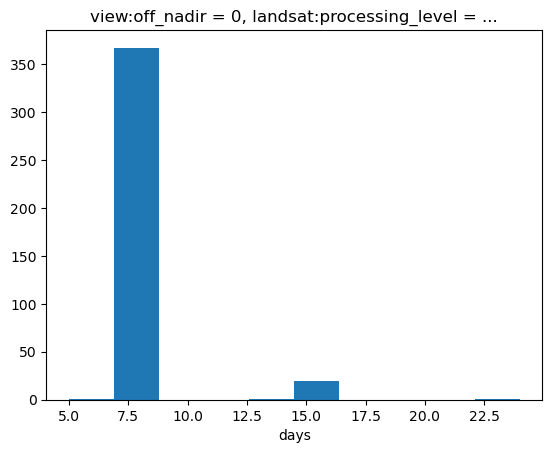

In [14]:
qa = stack.sel(band="QA_PIXEL").astype("uint16")
bad = qa & bitmask  # just look at those 4 bits

good = stack.where(bad == 0)  # mask pixels where any one of those bits are set
# What's the typical interval between scenes?
good.time.diff("time").dt.days.plot.hist();

In [15]:
# Make biannual median composites (`2Q` means 2 quarters)
composites = good.resample(time="2Q").median("time")
composites


<xarray.DataArray 'stackstac-9b05a59de0d0a53febaa5aecece8a274' (time: 19,
                                                                band: 19,
                                                                y: 773, x: 1172)>
dask.array<stack, shape=(19, 19, 773, 1172), dtype=float64, chunksize=(1, 1, 773, 942), chunktype=numpy.ndarray>
Coordinates: (12/13)
  * band                       (band) object 'coastal' ... 'SR_QA_AEROSOL'
  * x                          (x) float64 4.037e+05 4.038e+05 ... 4.389e+05
  * y                          (y) float64 4.623e+06 4.623e+06 ... 4.6e+06
    view:off_nadir             int64 0
    landsat:processing_level   <U4 'L2SP'
    instruments                object {'tirs', 'oli'}
    ...                         ...
    landsat:wrs_row            <U3 '031'
    platform                   <U9 'landsat-8'
    landsat:wrs_type           <U1 '2'
    proj:epsg                  int64 32619
    epsg                       int64 32619
  * time                       (time) datetime64[ns] 2013-03-31 ... 2022-03-31
Attributes:
    spec:        RasterSpec(epsg=32619, bounds=(403740.0, 4599690.0, 438900.0...
    crs:         epsg:32619
    transform:   | 30.00, 0.00, 403740.00|\n| 0.00,-30.00, 4622880.00|\n| 0.0...
    resolution:  30.0

In [16]:
rgb = composites.sel(band=["red", "green", "blue"])
rgb

<xarray.DataArray 'stackstac-9b05a59de0d0a53febaa5aecece8a274' (time: 19,
                                                                band: 3,
                                                                y: 773, x: 1172)>
dask.array<getitem, shape=(19, 3, 773, 1172), dtype=float64, chunksize=(1, 1, 773, 942), chunktype=numpy.ndarray>
Coordinates: (12/13)
  * band                       (band) object 'red' 'green' 'blue'
  * x                          (x) float64 4.037e+05 4.038e+05 ... 4.389e+05
  * y                          (y) float64 4.623e+06 4.623e+06 ... 4.6e+06
    view:off_nadir             int64 0
    landsat:processing_level   <U4 'L2SP'
    instruments                object {'tirs', 'oli'}
    ...                         ...
    landsat:wrs_row            <U3 '031'
    platform                   <U9 'landsat-8'
    landsat:wrs_type           <U1 '2'
    proj:epsg                  int64 32619
    epsg                       int64 32619
  * time                       (time) datetime64[ns] 2013-03-31 ... 2022-03-31
Attributes:
    spec:        RasterSpec(epsg=32619, bounds=(403740.0, 4599690.0, 438900.0...
    crs:         epsg:32619
    transform:   | 30.00, 0.00, 403740.00|\n| 0.00,-30.00, 4622880.00|\n| 0.0...
    resolution:  30.0

In [17]:
cleaned = rgb.ffill("time")[1:]

In [18]:
%%time
gif_img = geogif.dgif(cleaned).compute()

/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice e